--- Gas Turbine (Brayton) Cycle Results ---
T1 = 10.0 °C | s1 = 0.000 kJ/kg·K
T2 = 409.8 °C | s2 = 0.083 kJ/kg·K
T2s = 349.8 °C | s2s = 0.000 kJ/kg·K
T3 = 1582.4 °C | s3 = 1.212 kJ/kg·K
T4 = 670.0 °C | s4 = 1.360 kJ/kg·K
T4s = 570.2 °C | s3 = 1.212 kJ/kg·K
Turbine η_is = 90.14 %
Cycle efficiency check = 41.99 %
Qin = 1412.10 MWth
W_net_el   = 593.00 MW (Target: 593.00 MW)
W_comp = 481.47 MW
W_turb = 1098.74 MW
W_comp_is = 409.25 MW
W_turb_is = 1218.94 MW
W_comp_mech = 486.34 MW
W_turb_mech = 1087.76 MW
W_net_mech = 601.42 MW
W_net_el = 593.00 MW
Isentropic Turbine Loss (Loss_isen_t) [MW]: 120.19
Mechanical Loss (Loss_mech) [MW]: 6.17
Electrical Loss (Loss_el) [MW]: 8.42
Total Loss (Loss) [MW]: 14.593


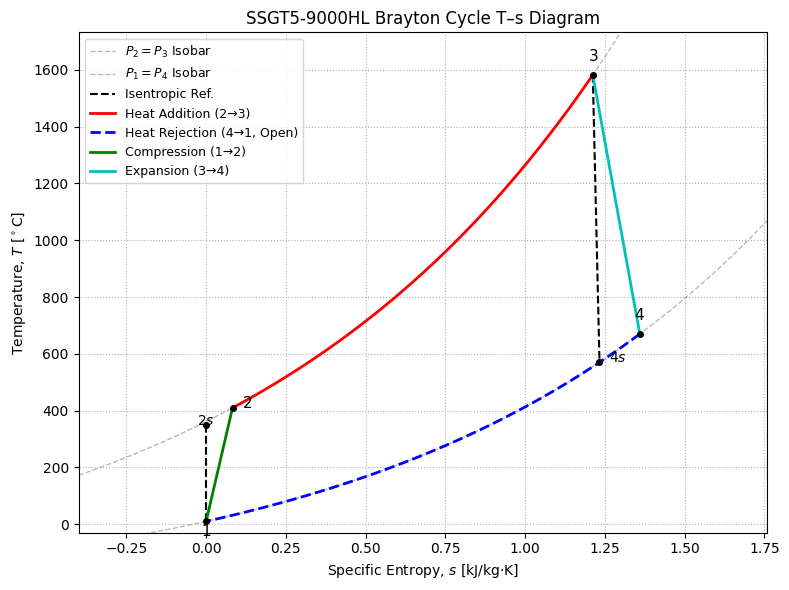

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Inputs ---
T1_C = 10                     # Ambient inlet [°C]
P1 = 101.3                    # Ambient pressure [kPa]
rp = 24                       # Compressor pressure ratio
eta_c = 0.85                  # Compressor efficiency
eta_m = 0.99                  # Shaft/Mech efficiency
eta_gen = 0.986               # Generator efficiency
eta_GT_net = 0.42             # Overall net GT efficiency
P_net_el = 593e6              # Net electrical output [W]
T4_C = 670                    # Flue gas exit temp [°C]
T4 = T4_C + 273.15            # Flue gas [K]

# --- 2. Gas properties (air approximation) ---
cp = 1.13                     # [kJ/kg·K]
k = 1.33
R = 0.287                     # [kJ/kg·K]
LHV = 48371.81e3              # Lower Heating Value [J/kg]

# --- 3. Unit conversion ---
cp_J = cp * 1e3               # [J/kg·K]

# --- 4. Compressor process 1→2 ---
T1 = T1_C + 273.15
T2s = T1 * (rp)**((k - 1)/k)
T2 = T1 + (T2s - T1)/eta_c
w_c = cp_J * (T2 - T1)

# --- 5. Iterative solution for T3 to match target net cycle efficiency ---
def find_T3(P_target):
    # T3 search range: 1200°C to 1800°C (K)
    for T3 in np.linspace(1200 + 273.15, 1800 + 273.15, 500):
        T4s = T3 * (1 / rp)**((k - 1)/k)
        eta_t = (T3 - T4) / (T3 - T4s)
        w_t = cp_J * (T3 - T4)
        w_net = (w_t * eta_m) - (w_c / eta_m)
        P_per_mass = w_net * eta_gen
        m_dot = P_target / P_per_mass
        Q_in = m_dot * cp_J * (T3 - T2)
        eff_check = P_target / Q_in
        if abs(eff_check - eta_GT_net) < 0.0001:
            return T3, T4s, eta_t, m_dot, eff_check
    return None, None, None, None, None

T3, T3s, eta_t, m_dot, eff_check = find_T3(P_net_el)

# --- 6. Entropy (relative, zero at 1) ---
s1 = 0
s2s = s1  # Isentropic compression
s2 = s1 + cp * np.log(T2 / T1) - R * np.log(rp)
s3 = s2 + cp * np.log(T3 / T2)
s3s = s3
s4 = s3 + cp * np.log(T4 / T3) - R * np.log(1 / rp)

# Calculate s4s for plotting the isentropic turbine path
T4s = T3 * (1 / rp)**((k - 1)/k)
s4s = s3 + cp * np.log(T4s / T3) - R * np.log(1 / rp)

# --- 7. Report and Power Calculations (MW) ---
W_comp_spec = w_c / 1e6  # MW/(kg/s)
W_turb_spec = cp_J * (T3 - T4) / 1e6  # MW/(kg/s)
W_comp = W_comp_spec * m_dot  # MW
W_turb = W_turb_spec * m_dot  # MW
W_comp_isen = W_comp*eta_c
W_turb_isen = W_turb/eta_t
W_comp_mech = W_comp / eta_m
W_turb_mech = W_turb * eta_m
W_net_mech = W_turb_mech - W_comp_mech
W_net_el = W_net_mech * eta_gen
Q_in_MW = (m_dot * cp_J * (T3 - T2)) / 1e6  # MW



Loss_isen_t = W_turb_isen - W_turb
Loss_mech = (W_turb-W_comp)*(1-eta_m)
Loss_el = W_net_mech*(1-eta_gen)
Losses =  Loss_mech + Loss_el

print("--- Gas Turbine (Brayton) Cycle Results ---")
print(f"T1 = {T1-273.15:.1f} °C | s1 = {s1:.3f} kJ/kg·K")
print(f"T2 = {T2-273.15:.1f} °C | s2 = {s2:.3f} kJ/kg·K")
print(f"T2s = {T2s-273.15:.1f} °C | s2s = {s2s:.3f} kJ/kg·K")
print(f"T3 = {T3-273.15:.1f} °C | s3 = {s3:.3f} kJ/kg·K")
print(f"T4 = {T4-273.15:.1f} °C | s4 = {s4:.3f} kJ/kg·K")
print(f"T4s = {T4s-273.15:.1f} °C | s3 = {s3:.3f} kJ/kg·K")
print(f"Turbine η_is = {eta_t*100:.2f} %")
print(f"Cycle efficiency check = {eff_check*100:.2f} %")
print(f"Qin = {Q_in_MW:.2f} MWth")
print(f"W_net_el   = {W_net_el:.2f} MW (Target: {P_net_el/1e6:.2f} MW)")

# Print power details requested by user
print(f"W_comp = {W_comp:.2f} MW")
print(f"W_turb = {W_turb:.2f} MW")
print(f"W_comp_is = {W_comp_isen:.2f} MW")
print(f"W_turb_is = {W_turb_isen:.2f} MW")
print(f"W_comp_mech = {W_comp_mech:.2f} MW")
print(f"W_turb_mech = {W_turb_mech:.2f} MW")
print(f"W_net_mech = {W_net_mech:.2f} MW")
print(f"W_net_el = {W_net_el:.2f} MW")

print(f"Isentropic Turbine Loss (Loss_isen_t) [MW]: {Loss_isen_t:.2f}")
print(f"Mechanical Loss (Loss_mech) [MW]: {Loss_mech:.2f}")
print(f"Electrical Loss (Loss_el) [MW]: {Loss_el:.2f}")
print(f"Total Loss (Loss) [MW]: {Losses:.3f}")
# --- 10. T–s Diagram ---
def K_to_C(T):
    return T - 273.15

plt.figure(figsize=(8,6))

# Define the overall plotting entropy range
s_min = min(s1, s2, s3, s4) - 0.4
s_max = max(s1, s2, s3, s4) + 0.4
s_iso_full = np.linspace(s_min, s_max, 300)

# --- Isobaric reference lines (span full graph) ---
T_iso_23 = T2 * np.exp((s_iso_full - s2)/cp)
T_iso_41 = T4 * np.exp((s_iso_full - s4)/cp)
plt.plot(s_iso_full, K_to_C(T_iso_23), '--', color='grey', lw=1, alpha=0.55, label=r'$P_2=P_3$ Isobar')
plt.plot(s_iso_full, K_to_C(T_iso_41), '--', color='grey', lw=1, alpha=0.55, label=r'$P_1=P_4$ Isobar')

# --- Isentropic reference lines ---
plt.plot([s1, s2s], [K_to_C(T1), K_to_C(T2s)], 'k--', lw=1.5, label='Isentropic Ref.') # 1-2s
plt.plot([s3, s4s], [K_to_C(T3), K_to_C(T4s)], 'k--', lw=1.5) # 3-4s

# --- Actual steps along isobars ---
s_iso_23_step = np.linspace(s2, s3, 50)
T_iso_23_step = T2 * np.exp((s_iso_23_step - s2)/cp)
plt.plot(s_iso_23_step, K_to_C(T_iso_23_step), 'r-', lw=2, label='Heat Addition (2→3)')

s_iso_41_step = np.linspace(s4, s1, 50)
T_iso_41_step = T4 * np.exp((s_iso_41_step - s4)/cp)
plt.plot(s_iso_41_step, K_to_C(T_iso_41_step), 'b--', lw=2, label='Heat Rejection (4→1, Open)')

# --- Actual adiabatic (compression & expansion) ---
plt.plot([s1, s2], [K_to_C(T1), K_to_C(T2)], 'g-', lw=2, label='Compression (1→2)')
plt.plot([s3, s4], [K_to_C(T3), K_to_C(T4)], 'c-', lw=2, label='Expansion (3→4)')

# --- Cycle points ---
plt.plot([s1, s2, s3, s4, s2s, s4s], [K_to_C(T1), K_to_C(T2), K_to_C(T3), K_to_C(T4), K_to_C(T2s), K_to_C(T4s)], 'ko', markersize=4)

plt.text(s1, K_to_C(T1)-50, r'$1$', fontsize=11, ha='center', fontweight='bold')
plt.text(s2+0.03, K_to_C(T2), r'$2$', fontsize=11, fontweight='bold')
plt.text(s3, K_to_C(T3)+50, r'$3$', fontsize=11, ha='center', fontweight='bold')
plt.text(s4, K_to_C(T4)+50, r'$4$', fontsize=11, ha='center', fontweight='bold')
plt.text(s2s-0.03, K_to_C(T2s), r'$2s$', fontsize=10)
plt.text(s4s+0.03, K_to_C(T4s), r'$4s$', fontsize=10)

plt.xlabel(r'Specific Entropy, $s$ [kJ/kg·K]')
plt.ylabel(r'Temperature, $T$ [$^\circ$C]')
plt.title('SSGT5-9000HL Brayton Cycle T–s Diagram')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, linestyle=':')
plt.xlim(s_min, s_max)
plt.ylim(K_to_C(min(T1, T2, T3, T4)) - 40, K_to_C(max(T1, T2, T3, T4)) + 150)
plt.tight_layout()
plt.show()
